In [1]:
# 1. Imports and Setup

import sys, os

sys.path.append(os.path.abspath(".."))
from notebook_setup import *

tracker = ExperimentTracker()

Checking for crucial dependencies...
  -> Chronos: Available
  -> TimeGPT: Available
  -> API Key: Found
Notebook setup complete.


Dataset: FRED GPDIC1 Investments Quarterly
Total: 315 | Train: 307 | Test: 8
Train period: 1947-01-01 to 2023-07-01
Test period:  2023-10-01 to 2025-07-01
Seasonal period: 4


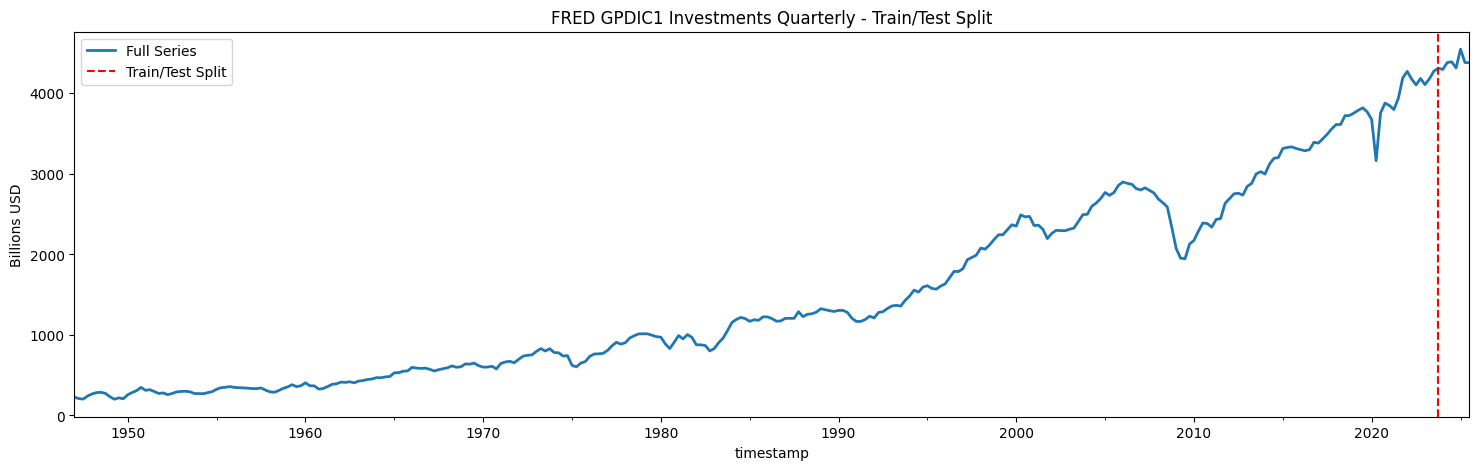

In [2]:
# 2. Data Loading and Configuration

# === DATASET CONFIGURATION ===
DATASET_CONFIG = {
    "file_path": "../datasets/fred_gpdic1_investments_quarterly.csv",
    "time_column": "timestamp",
    "target_column": "investments",
    "frequency": "QS",  # 'MS'=monthly start, 'QS'=quarterly, 'YS'=yearly, 'H'=hourly, 'D'=daily
    "test_periods": 8,  # Number of periods to hold out for testing
    "seasonal_period": 4,  # 12=monthly, 4=quarterly, 1=yearly, 24=hourly, 7=daily
    "name": "FRED GPDIC1 Investments Quarterly",
    "value_unit": "Billions USD",  # Unit label for Y-axis in visualizations
}

# === LOAD AND PREPROCESS DATA ===
df = pd.read_csv(DATASET_CONFIG["file_path"])
df[DATASET_CONFIG["time_column"]] = pd.to_datetime(df[DATASET_CONFIG["time_column"]])
series = TimeSeries.from_dataframe(
    df, DATASET_CONFIG["time_column"], DATASET_CONFIG["target_column"]
)
series = series.astype(np.float32)

# === TRAIN/TEST SPLIT ===
# Test set is held out completely - models never see it during training or validation
freq = DATASET_CONFIG["frequency"]
test_periods = DATASET_CONFIG["test_periods"]
offset_map = {
    "MS": pd.DateOffset(months=test_periods),
    "QS": pd.DateOffset(months=test_periods * 3),
    "YS": pd.DateOffset(years=test_periods),
    "D": pd.DateOffset(days=test_periods),
    "H": pd.DateOffset(hours=test_periods),
}
offset = offset_map.get(freq, pd.DateOffset(days=test_periods))

train, test = series.split_after(pd.Timestamp(series.end_time()) - offset)

# === SCALING (for Deep Learning models) ===
# IMPORTANT: Scaler is fitted ONLY on training data to prevent data leakage
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)  # Transform only, no fitting
series_scaled = scaler.transform(series)

print(f"Dataset: {DATASET_CONFIG['name']}")
print(f"Total: {len(series)} | Train: {len(train)} | Test: {len(test)}")
print(f"Train period: {train.start_time().date()} to {train.end_time().date()}")
print(f"Test period:  {test.start_time().date()} to {test.end_time().date()}")
print(f"Seasonal period: {DATASET_CONFIG['seasonal_period']}")

series.plot(label="Full Series", figsize=(18, 5))
plt.axvline(x=test.start_time(), color="red", linestyle="--", label="Train/Test Split")
plt.title(f"{DATASET_CONFIG['name']} - Train/Test Split")
if "value_unit" in DATASET_CONFIG:
    plt.ylabel(DATASET_CONFIG["value_unit"])
plt.legend()
plt.show()

In [3]:
# 3. Constants

SEASONAL_PERIOD = DATASET_CONFIG["seasonal_period"]
STAT_GRIDS = get_statistical_grids(SEASONAL_PERIOD)
DL_GRIDS = get_dl_grids(SEASONAL_PERIOD)

TEST_PERIODS = DATASET_CONFIG["test_periods"]

USE_FULL_GRID = TUNING_CONFIG["USE_FULL_GRID"]
N_ITER = TUNING_CONFIG["N_ITER"]

In [4]:
# 4. Statistical Models

# Holt-Winters
run_tuning_and_eval(
    tracker,
    "Holt-Winters",
    ExponentialSmoothing,
    STAT_GRIDS["Holt-Winters"],
    train,
    test_periods=TEST_PERIODS,
)

# AutoARIMA
run_tuning_and_eval(
    tracker,
    "AutoARIMA",
    AutoARIMA,
    STAT_GRIDS["AutoARIMA"],
    train,
    test_periods=TEST_PERIODS,
)


# Prophet
run_tuning_and_eval(
    tracker,
    "Prophet",
    Prophet,
    STAT_GRIDS["Prophet"],
    train,
    test_periods=TEST_PERIODS,
)

Holt-Winters: 100%|██████████| 15/15 [00:50<00:00,  3.38s/it, best=374.98, rmse=374.98]


Holt-Winters: RMSE=374.9760 | MAPE=11.21% | Time=50.7s (15 combinations)


AutoARIMA: 100%|██████████| 1/1 [00:32<00:00, 32.78s/it, best=inf, rmse=391.36]


AutoARIMA: RMSE=391.3599 | MAPE=10.90% | Time=32.8s (1 combinations)


Prophet: 100%|██████████| 6/6 [00:45<00:00,  7.61s/it, best=430.47, rmse=481.76]

Prophet: RMSE=430.4659 | MAPE=13.13% | Time=45.7s (6 combinations)


{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01}

In [5]:
# 5. Deep Learning Models

# TiDE
run_tuning_and_eval(
    tracker,
    "TiDE",
    TiDEModel,
    DL_GRIDS["TiDE"],
    train_scaled,
    is_dl=True,
    use_full_grid=USE_FULL_GRID,
    n_iter=N_ITER,
    scaler=scaler,
    original_train=train,
    test_periods=TEST_PERIODS,
)

# N-BEATS
run_tuning_and_eval(
    tracker,
    "N-BEATS",
    NBEATSModel,
    DL_GRIDS["N-BEATS"],
    train_scaled,
    is_dl=True,
    use_full_grid=USE_FULL_GRID,
    n_iter=N_ITER,
    scaler=scaler,
    original_train=train,
    test_periods=TEST_PERIODS,
)

# TFT
run_tuning_and_eval(
    tracker,
    "TFT",
    TFTModel,
    DL_GRIDS["TFT"],
    train_scaled,
    is_dl=True,
    use_full_grid=USE_FULL_GRID,
    n_iter=N_ITER,
    scaler=scaler,
    original_train=train,
    test_periods=TEST_PERIODS,
)

TiDE: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s, best=370.46, rmse=381.46]


TiDE: RMSE=370.4615 | MAPE=10.15% | Time=7.8s (10 combinations)


N-BEATS: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it, best=444.01, rmse=721.12]


N-BEATS: RMSE=444.0144 | MAPE=12.08% | Time=23.1s (10 combinations)


TFT: 100%|██████████| 10/10 [00:29<00:00,  2.93s/it, best=1051.56, rmse=1449.07]

TFT: RMSE=1051.5613 | MAPE=26.13% | Time=29.3s (10 combinations)


{'input_chunk_length': 4,
 'output_chunk_length': 4,
 'n_epochs': 30,
 'batch_size': 32,
 'random_state': 42,
 'hidden_size': 64,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [6]:
# 6. Foundation Models (Chronos, TimeGPT)

run_foundation_models(tracker, train, test, DATASET_CONFIG["frequency"])

Chronos: RMSE=237.5805 | MAPE=5.41% | Time=1.6s (1 combinations)
TimeGPT: RMSE=359.6429 | MAPE=8.36% | Time=1.6s (1 combinations)


In [7]:
# 7. Results Comparison (Cross-Validation Metrics)

results_df = tracker.get_results_df()
print("=== Cross-Validation Results ===")
print(
    results_df[["Model", "RMSE", "MAPE", "Tuning Time (s)", "Combinations"]].to_string(
        index=False
    )
)

=== Cross-Validation Results ===
       Model        RMSE      MAPE  Tuning Time (s)  Combinations
     Chronos  237.580460  5.413623         1.612764             1
     TimeGPT  359.642898  8.356610         1.629619             1
        TiDE  370.461517 10.145566         7.788735            10
Holt-Winters  374.975966 11.207249        50.704792            15
   AutoARIMA  391.359911 10.898493        32.779352             1
     Prophet  430.465888 13.131018        45.666569             6
     N-BEATS  444.014435 12.077441        23.119355            10
         TFT 1051.561279 26.130175        29.344520            10


In [ ]:
# 8. Train Final Predictions with Best and Fastest Models

final_predictions = get_final_predictions(
    tracker, train, test, scaler, train_scaled, DATASET_CONFIG["frequency"]
)

Retraining Best: Chronos


In [ ]:
# 9. Visualize Final Predictions with Best and Fastest Models (Interactive)

fig = plot_forecast_comparison(
    train,
    test,
    final_predictions,
    DATASET_CONFIG["name"],
    target_column=DATASET_CONFIG.get("target_column"),
    value_unit=DATASET_CONFIG.get("value_unit"),
)
fig.show()

In [10]:
# 10. All Models Comparison (Interactive)

fig_comparison = plot_model_comparison(
    tracker.get_results_df(),
    DATASET_CONFIG["name"],
    value_unit=DATASET_CONFIG.get("value_unit"),
)
fig_comparison.show()

In [11]:
# 11. Export Static PNG Images for GitHub

export_plots(fig, fig_comparison, DATASET_CONFIG["name"])